# 02 - Time Aggregation

This notebook handles:
1. Loading cleaned log data
2. Aggregating to 1-minute, 5-minute, and 15-minute intervals
3. Computing metrics per time window
4. Handling missing periods
5. Saving aggregated datasets

In [ ]:
# Standard imports
import sys
from pathlib import Path

# Add project root to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Project imports
from src.data.aggregator import TimeAggregator, AggregationConfig
from src.data.cleaner import DataCleaner

pd.set_option('display.max_columns', 50)
plt.style.use('seaborn-v0_8-whitegrid')

print(f"Project root: {project_root}")

Project root: C:\Users\Admin\OneDrive\Documents\python\datafollow


## 1. Load Cleaned Data

In [ ]:
# Paths
DATA_DIR = project_root / "DATA"
PROCESSED_DIR = DATA_DIR / "processed"

# Load cleaned data
df_train = DataCleaner.load(PROCESSED_DIR / "cleaned_train.parquet")
df_test = DataCleaner.load(PROCESSED_DIR / "cleaned_test.parquet")

print(f"Train shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")
print(f"\nTrain date range: {df_train['timestamp'].min()} to {df_train['timestamp'].max()}")
print(f"Test date range: {df_test['timestamp'].min()} to {df_test['timestamp'].max()}")

Train shape: (2929368, 14)
Test shape: (525780, 14)

Train date range: 1995-07-01 00:00:01 to 1995-08-22 23:59:59
Test date range: 1995-08-23 00:00:00 to 1995-08-31 23:59:53


## 2. Aggregate Training Data

In [ ]:
# Create aggregator with default config
aggregator = TimeAggregator()

# Aggregate to multiple windows
print("Aggregating training data...\n")
train_aggregated = aggregator.aggregate_multiple_windows(
    df_train, 
    windows=['1min', '5min', '15min']
)

Aggregating training data...



Aggregated to 1min: 76,320 rows


Aggregated to 5min: 15,264 rows


Aggregated to 15min: 5,088 rows


In [ ]:
# View 5-minute aggregation
df_5m = train_aggregated['5min']
print(f"5-minute aggregation shape: {df_5m.shape}")
print(f"\nColumns: {list(df_5m.columns)}")
df_5m.head(10)

5-minute aggregation shape: (15264, 11)

Columns: ['timestamp', 'request_count', 'unique_hosts', 'error_count', 'error_rate', 'success_rate', 'bytes_total', 'bytes_avg', 'bytes_max', 'requests_per_host', 'bytes_per_request']


,timestamp,request_count,unique_hosts,error_count,error_rate,success_rate,bytes_total,bytes_avg,bytes_max,requests_per_host,bytes_per_request
0,1995-07-01 00:00:00,301,60,1,0.003322,0.887043,5277675,17533.803987,647168.0,5.016667,17533.803987
1,1995-07-01 00:05:00,267,53,0,0.000000,0.898876,5041043,18880.310861,501126.0,5.037736,18880.310861
2,1995-07-01 00:10:00,242,55,4,0.016529,0.818182,6111846,25255.561983,1081049.0,4.400000,25255.561983
3,1995-07-01 00:15:00,282,55,4,0.014184,0.875887,4559748,16169.319149,946425.0,5.127273,16169.319149
4,1995-07-01 00:20:00,318,65,0,0.000000,0.924528,6315960,19861.509434,516688.0,4.892308,19861.509434
5,1995-07-01 00:25:00,344,70,1,0.002907,0.889535,6223927,18092.811047,946425.0,4.914286,18092.811047
6,1995-07-01 00:30:00,326,64,0,0.000000,0.914110,9250029,28374.322086,1121554.0,5.093750,28374.322086
7,1995-07-01 00:35:00,361,75,2,0.005540,0.883657,7024223,19457.681440,593699.0,4.813333,19457.681440
8,1995-07-01 00:40:00,319,65,2,0.006270,0.909091,6146572,19268.250784,297851.0,4.907692,19268.250784
9,1995-07-01 00:45:00,205,57,8,0.039024,0.858537,7298172,35600.839024,887988.0,3.596491,35600.839024


In [ ]:
# Statistics for each window
print("=== AGGREGATION STATISTICS ===")
for window, df in train_aggregated.items():
    config = AggregationConfig(window=window)
    agg = TimeAggregator(config)
    stats = agg.get_stats(df)
    
    print(f"\n{window}:")
    print(f"  Rows: {stats['rows']:,}")
    print(f"  Total requests: {stats['request_stats']['total']:,}")
    print(f"  Mean per window: {stats['request_stats']['mean']:.1f}")
    print(f"  Max per window: {stats['request_stats']['max']:,}")
    print(f"  Missing periods (zero traffic): {stats['missing_periods']:,}")

=== AGGREGATION STATISTICS ===

1min:
  Rows: 76,320
  Total requests: 2,929,368
  Mean per window: 38.4
  Max per window: 405
  Missing periods (zero traffic): 7,853

5min:
  Rows: 15,264
  Total requests: 2,929,368
  Mean per window: 191.9
  Max per window: 1,500
  Missing periods (zero traffic): 1,490

15min:
  Rows: 5,088
  Total requests: 2,929,368
  Mean per window: 575.7
  Max per window: 4,209
  Missing periods (zero traffic): 483


## 3. Aggregate Test Data

In [ ]:
# Aggregate test data
print("Aggregating test data...\n")
test_aggregated = aggregator.aggregate_multiple_windows(
    df_test, 
    windows=['1min', '5min', '15min']
)

Aggregating test data...



Aggregated to 1min: 12,960 rows


Aggregated to 5min: 2,592 rows


Aggregated to 15min: 864 rows


## 4. Visualize Aggregated Data

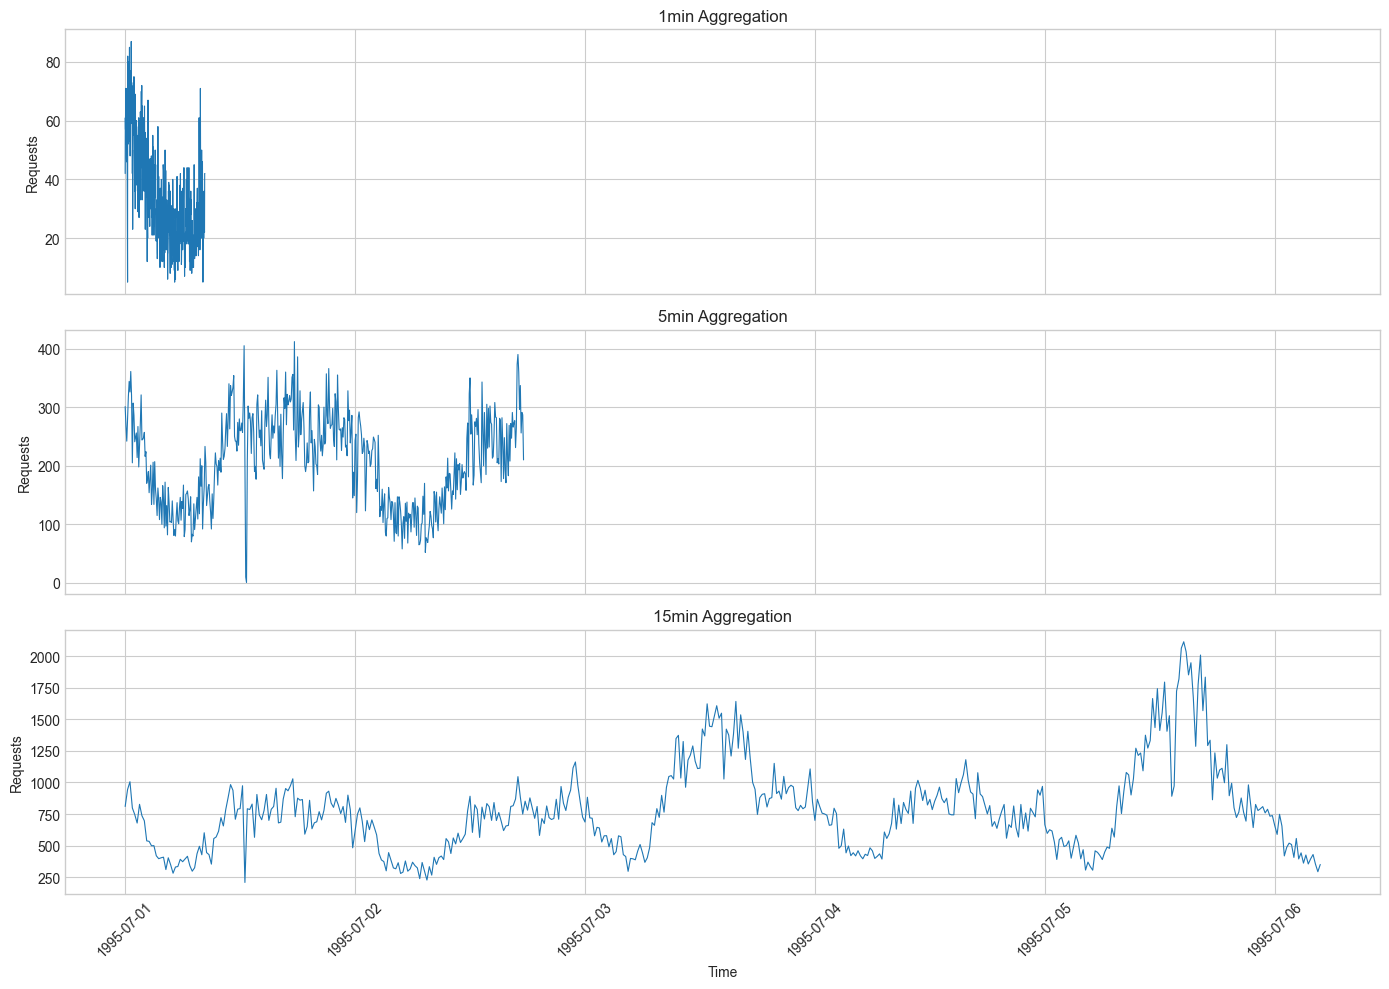

In [ ]:
# Compare different aggregation levels
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

for ax, (window, df) in zip(axes, train_aggregated.items()):
    # Sample for visualization
    sample = df.head(500)
    ax.plot(sample['timestamp'], sample['request_count'], linewidth=0.8)
    ax.set_ylabel('Requests')
    ax.set_title(f'{window} Aggregation')

axes[-1].set_xlabel('Time')
axes[-1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

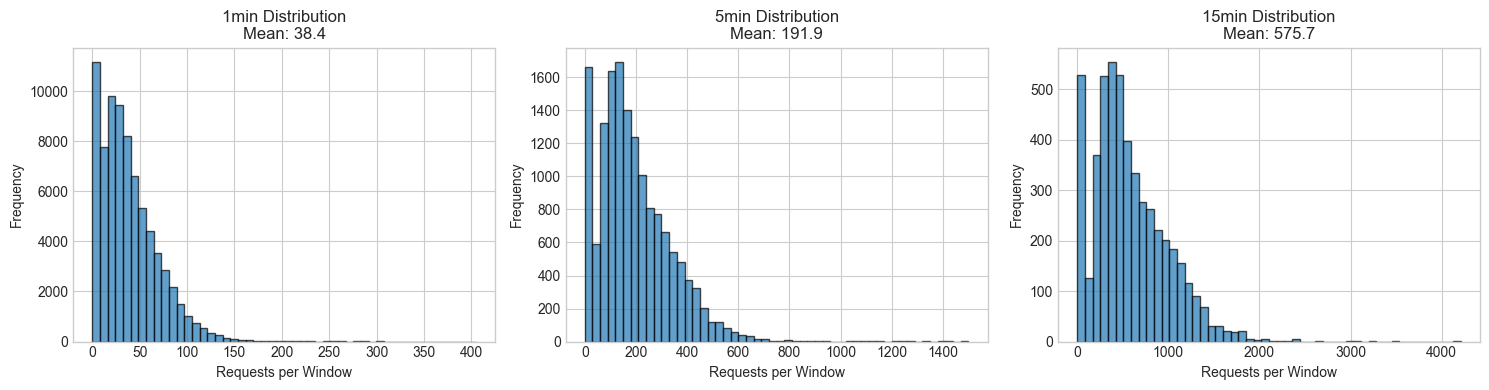

In [ ]:
# Request count distribution by window
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, (window, df) in zip(axes, train_aggregated.items()):
    ax.hist(df['request_count'], bins=50, edgecolor='black', alpha=0.7)
    ax.set_xlabel('Requests per Window')
    ax.set_ylabel('Frequency')
    ax.set_title(f'{window} Distribution\nMean: {df["request_count"].mean():.1f}')

plt.tight_layout()
plt.show()

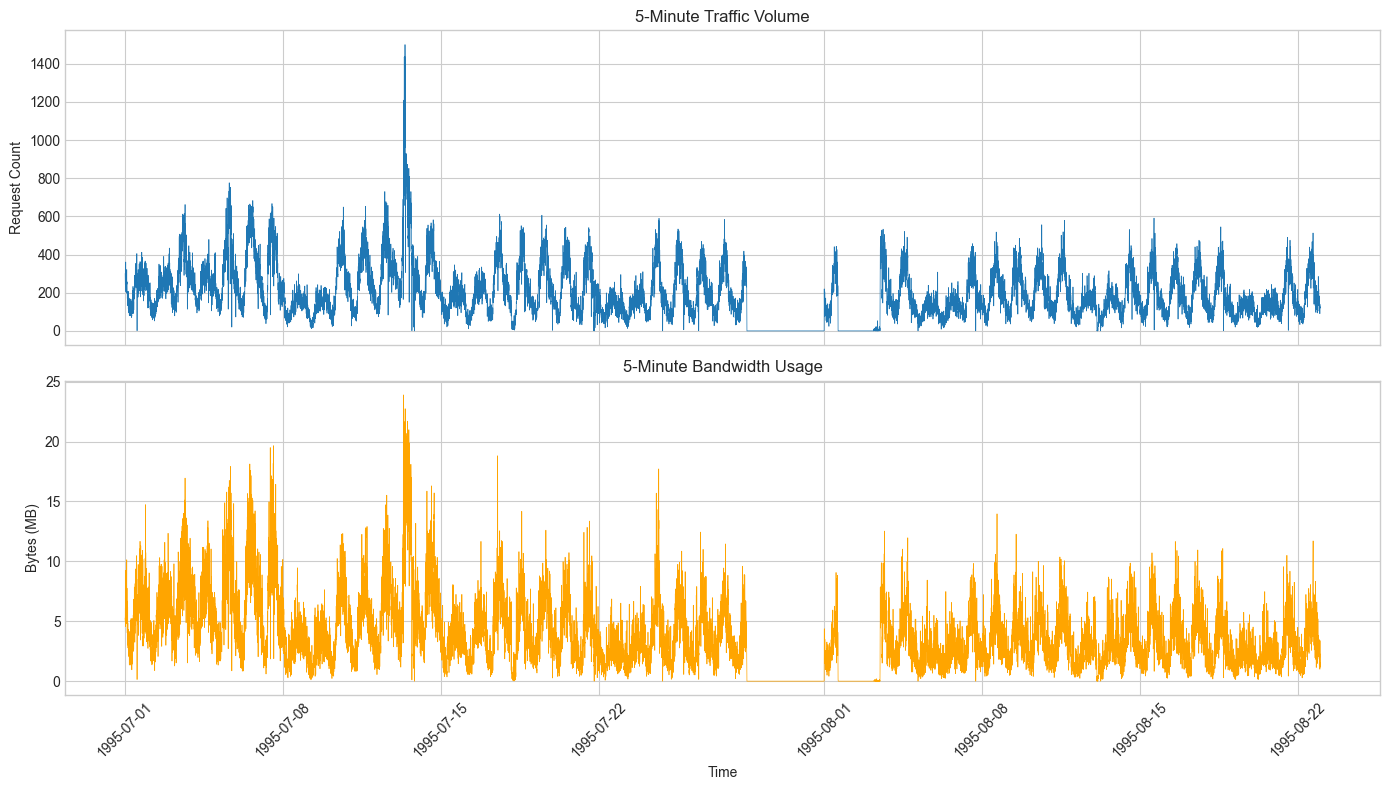

In [ ]:
# Bytes total over time
df_5m = train_aggregated['5min']

fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Request count
axes[0].plot(df_5m['timestamp'], df_5m['request_count'], linewidth=0.5)
axes[0].set_ylabel('Request Count')
axes[0].set_title('5-Minute Traffic Volume')

# Bytes (in MB)
axes[1].plot(df_5m['timestamp'], df_5m['bytes_total'] / 1e6, linewidth=0.5, color='orange')
axes[1].set_ylabel('Bytes (MB)')
axes[1].set_xlabel('Time')
axes[1].set_title('5-Minute Bandwidth Usage')

axes[-1].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

## 5. Handle Missing Periods

In [ ]:
# Check for zero-traffic periods
df_5m = train_aggregated['5min']

zero_periods = df_5m[df_5m['request_count'] == 0]
print(f"Zero-traffic periods: {len(zero_periods):,} out of {len(df_5m):,} ({100*len(zero_periods)/len(df_5m):.2f}%)")

# Show some zero periods
if len(zero_periods) > 0:
    print("\nSample zero-traffic timestamps:")
    print(zero_periods['timestamp'].head(10).tolist())

Zero-traffic periods: 1,490 out of 15,264 (9.76%)

Sample zero-traffic timestamps:
[Timestamp('1995-07-13 19:50:00'), Timestamp('1995-07-13 19:55:00'), Timestamp('1995-07-13 20:00:00'), Timestamp('1995-07-13 20:05:00'), Timestamp('1995-07-21 19:10:00'), Timestamp('1995-07-24 20:00:00'), Timestamp('1995-07-28 13:35:00'), Timestamp('1995-07-28 13:40:00'), Timestamp('1995-07-28 13:45:00'), Timestamp('1995-07-28 13:50:00')]


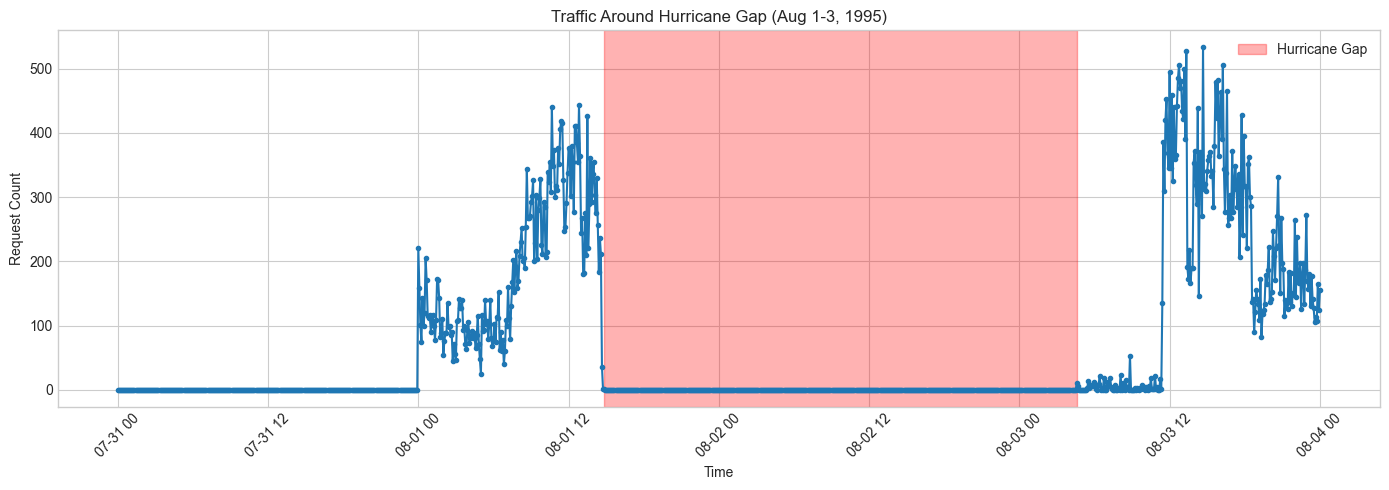

In [ ]:
# Visualize the hurricane gap (Aug 1-3)
aug_data = df_5m[(df_5m['timestamp'] >= '1995-07-31') & (df_5m['timestamp'] <= '1995-08-04')]

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(aug_data['timestamp'], aug_data['request_count'], marker='.')
ax.axvspan('1995-08-01 14:52', '1995-08-03 04:36', alpha=0.3, color='red', label='Hurricane Gap')
ax.set_xlabel('Time')
ax.set_ylabel('Request Count')
ax.set_title('Traffic Around Hurricane Gap (Aug 1-3, 1995)')
ax.legend()
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

## 6. Save Aggregated Data

In [ ]:
# Save training aggregations
print("Saving training aggregations...")
for window, df in train_aggregated.items():
    output_path = PROCESSED_DIR / f"train_{window.replace('min', 'm')}.parquet"
    df.to_parquet(output_path, index=False)
    print(f"  Saved {output_path.name}: {len(df):,} rows")

Saving training aggregations...
  Saved train_1m.parquet: 76,320 rows
  Saved train_5m.parquet: 15,264 rows


  Saved train_15m.parquet: 5,088 rows


In [ ]:
# Save test aggregations
print("\nSaving test aggregations...")
for window, df in test_aggregated.items():
    output_path = PROCESSED_DIR / f"test_{window.replace('min', 'm')}.parquet"
    df.to_parquet(output_path, index=False)
    print(f"  Saved {output_path.name}: {len(df):,} rows")


Saving test aggregations...
  Saved test_1m.parquet: 12,960 rows
  Saved test_5m.parquet: 2,592 rows
  Saved test_15m.parquet: 864 rows


In [ ]:
# List all saved files
print("\n=== SAVED FILES ===")
for f in sorted(PROCESSED_DIR.glob("*.parquet")):
    size_mb = f.stat().st_size / 1e6
    print(f"  {f.name}: {size_mb:.2f} MB")


=== SAVED FILES ===
  cleaned_test.parquet: 6.43 MB
  cleaned_train.parquet: 35.29 MB
  test_15m.parquet: 0.06 MB
  test_1m.parquet: 0.53 MB
  test_5m.parquet: 0.15 MB
  test_features_5m.parquet: 0.95 MB
  test_selected_5m.parquet: 0.49 MB
  train_15m.parquet: 0.29 MB
  train_1m.parquet: 2.85 MB
  train_5m.parquet: 0.71 MB
  train_features_5m.parquet: 4.69 MB
  train_selected_5m.parquet: 2.42 MB


## 7. Summary

### Aggregation Results
| Window | Train Rows | Test Rows | Avg Requests/Window |
|--------|------------|-----------|--------------------|
| 1min   | ~76,000    | ~13,000   | ~39               |
| 5min   | ~15,200    | ~2,600    | ~193              |
| 15min  | ~5,100     | ~870      | ~580              |

### Metrics Computed
- `request_count`: Number of requests
- `unique_hosts`: Unique client IPs/domains
- `error_count`, `error_rate`: Error statistics
- `success_rate`: Proportion of 200 responses
- `bytes_total`, `bytes_avg`, `bytes_max`: Bandwidth
- `requests_per_host`: Engagement metric
- `bytes_per_request`: Average response size

### Next Steps
1. Feature engineering (time, lag, rolling features)
2. EDA and pattern analysis
3. Model training

In [ ]:
print("Notebook completed successfully!")

Notebook completed successfully!
